In [78]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random 

from ChemClean import *
from Descriptors import *

In [2]:
import rdkit.Chem as Chem
from rdkit.Chem import rdMolDescriptors 

In [3]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import shuffle

import statsmodels.api as sm

## Load data from url

In [4]:
url='https://raw.githubusercontent.com/akashjn/DataScience/main/Data/BTZ_5442mols_smiles_redpot.csv'
data=pd.read_csv(url)
data=data.sample(frac=1)
data.index=range(data.shape[0])
data.head()

,SMILES,ERed
0,CNc1c(C)cc(N(C)C)c2nsnc12,1.48
1,CCCN1CCN(C(C)CC)c2c1cc1nsnc1c2OC,1.53
2,COCCNc1cc2nsnc2c(OC)c1N,1.30
3,CCOc1c2c(cc3nsnc13)N(C)CCN2CCOC,1.34
4,COc1c2c(c(OC)c3nsnc13)N(CC(C)C)CN2C,1.14


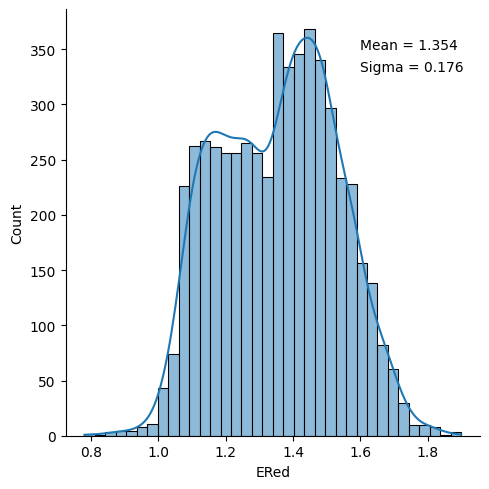

In [6]:
ax=sns.displot(data, x="ERed",kde=True)
plt.text(1.6,350,'Mean = '+str(np.round(np.mean(data['ERed']),3)))
plt.text(1.6,330,'Sigma = '+str(np.round(np.std(data['ERed']),3)))
plt.show()

## Generate descriptors using Descriptors.py

In [7]:
%%time
p=desc(data['SMILES'][:5000])
df_rdkit=p.RDkit_descriptors()
print(df_rdkit.shape)
df_rdkit.head()

(5000, 208)
CPU times: user 43.9 s, sys: 188 ms, total: 44.1 s
Wall time: 44.1 s


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,4.338519,0.964074,4.338519,0.964074,0.844604,222.317,208.205,222.093917,80,0,...,0,0,0,0,0,0,0,0,0,0
1,5.771440,0.486548,5.771440,0.486548,0.842727,320.462,296.270,320.167082,120,0,...,0,0,0,0,0,0,0,0,0,0
2,6.009880,0.545188,6.009880,0.545188,0.618671,254.315,240.203,254.083747,92,0,...,0,0,0,0,0,0,0,0,1,0
3,5.929456,0.615984,5.929456,0.615984,0.841829,308.407,288.247,308.130697,114,0,...,0,0,0,0,0,0,0,0,0,0
4,5.668596,0.559543,5.668596,0.559543,0.865088,308.407,288.247,308.130697,114,0,...,0,0,0,0,0,0,0,0,0,0


## Data cleaning operations from ChemClean.py

In [8]:
p=clean(df_rdkit)

In [9]:
p.remove_nan().head()
p.remove_unique().head()
p.remove_columns_low_std(0.1).head()
df_model=p.remove_corr_features(0.7)
print(df_model.shape)
df_model.head()

Removing 0 columns with nan, if any
Before: df.shape=(5000, 208)
After: df.shape=(5000, 208) 

removing 84 columns values with a unique value
Before: df.shape=(5000, 208)
After: df.shape=(5000, 124) 

Removed 10 columns with std < 0.1 
Dropped 75 features with correlation coeff. > 0.70
(5000, 39)


,MaxEStateIndex,MinEStateIndex,MolWt,FpDensityMorgan1,BCUT2D_MWLOW,BCUT2D_LOGPLOW,BalabanJ,HallKierAlpha,PEOE_VSA10,PEOE_VSA11,...,VSA_EState2,VSA_EState8,VSA_EState9,NHOHCount,NumAliphaticHeterocycles,fr_ArN,fr_Ndealkylation1,fr_aryl_methyl,fr_bicyclic,fr_unbrch_alkane
0,4.338519,0.964074,222.317,1.266667,10.112227,-2.097592,2.804562,-1.36,11.033401,0.000000,...,2.065648,2.080972,5.954036,1,0,0,0,1,1,0
1,5.771440,0.486548,320.462,1.318182,10.061294,-2.450428,2.215199,-1.56,16.720788,5.749512,...,4.925231,9.882587,1.738054,0,1,0,0,0,2,0
2,6.009880,0.545188,254.315,1.411765,10.183488,-2.094858,2.376001,-1.60,16.720788,5.749512,...,0.000000,1.279796,3.224783,3,0,1,0,0,1,1
3,5.929456,0.615984,308.407,1.333333,10.108201,-2.406108,2.150945,-1.60,16.720788,5.749512,...,4.571980,6.089174,3.835153,0,1,0,1,0,2,0
4,5.668596,0.559543,308.407,1.095238,10.127308,-2.307965,2.293455,-1.76,11.374773,22.532425,...,4.498009,6.199854,5.429884,0,1,0,0,0,2,0


In [10]:
alpha=0.02
target=data['ERed'][:5000]
features=df_model.copy()
features.shape
features.head()

,MaxEStateIndex,MinEStateIndex,MolWt,FpDensityMorgan1,BCUT2D_MWLOW,BCUT2D_LOGPLOW,BalabanJ,HallKierAlpha,PEOE_VSA10,PEOE_VSA11,...,VSA_EState2,VSA_EState8,VSA_EState9,NHOHCount,NumAliphaticHeterocycles,fr_ArN,fr_Ndealkylation1,fr_aryl_methyl,fr_bicyclic,fr_unbrch_alkane
0,4.338519,0.964074,222.317,1.266667,10.112227,-2.097592,2.804562,-1.36,11.033401,0.000000,...,2.065648,2.080972,5.954036,1,0,0,0,1,1,0
1,5.771440,0.486548,320.462,1.318182,10.061294,-2.450428,2.215199,-1.56,16.720788,5.749512,...,4.925231,9.882587,1.738054,0,1,0,0,0,2,0
2,6.009880,0.545188,254.315,1.411765,10.183488,-2.094858,2.376001,-1.60,16.720788,5.749512,...,0.000000,1.279796,3.224783,3,0,1,0,0,1,1
3,5.929456,0.615984,308.407,1.333333,10.108201,-2.406108,2.150945,-1.60,16.720788,5.749512,...,4.571980,6.089174,3.835153,0,1,0,1,0,2,0
4,5.668596,0.559543,308.407,1.095238,10.127308,-2.307965,2.293455,-1.76,11.374773,22.532425,...,4.498009,6.199854,5.429884,0,1,0,0,0,2,0


## Feature elimination using p-value test; using Linear Regression

In [11]:
for a in range(100):
    mod = sm.OLS(target,features)
    fii = mod.fit()
    p_values = fii.summary2().tables[1]['P>|t|']
    cols=[]
    for i in range(len(p_values)):
        if p_values[i]>alpha:
            cols.append(p_values.index[i])
    if len(cols)==0:
        break
    print(len(cols),'descriptors eliminated in iteration',str(a+1))
    features.drop(columns=cols,inplace=True)
    
print('Final model has',features.shape,'desriptors')
features.columns

6 descriptors eliminated in iteration 1
1 descriptors eliminated in iteration 2
Final model has (5000, 32) desriptors


Index(['MaxEStateIndex', 'MolWt', 'FpDensityMorgan1', 'BCUT2D_LOGPLOW',
       'BalabanJ', 'HallKierAlpha', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12',
       'PEOE_VSA2', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9',
       'SMR_VSA10', 'SMR_VSA4', 'SMR_VSA5', 'SlogP_VSA3', 'SlogP_VSA4',
       'SlogP_VSA6', 'EState_VSA4', 'EState_VSA6', 'EState_VSA7',
       'EState_VSA8', 'VSA_EState2', 'VSA_EState9', 'NHOHCount',
       'NumAliphaticHeterocycles', 'fr_ArN', 'fr_Ndealkylation1',
       'fr_bicyclic', 'fr_unbrch_alkane'],
      dtype='object')

## 5-fold cross-validated Linear Regression using entire dataset

In [27]:
# This cell executes CROSS-VALIDATED linear regression

features_std = StandardScaler().fit_transform(features)

lr = LinearRegression()
scores=cross_validate(lr,features_std,target,cv=5,return_train_score=True,scoring='r2')
scores

{'fit_time': array([0.00816298, 0.03517318, 0.02438426, 0.03957796, 0.02154493]),
 'score_time': array([0.00613213, 0.00916433, 0.00235343, 0.0056386 , 0.01694965]),
 'test_score': array([0.76805527, 0.7681095 , 0.76346066, 0.78162092, 0.75170212]),
 'train_score': array([0.77074726, 0.77063309, 0.77168081, 0.76714663, 0.77414298])}

## 5-fold cross-validated predictions using Linear Regression for entire dataset

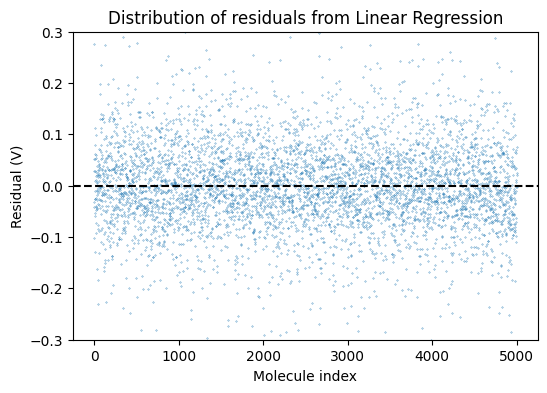

In [87]:
plt.figure(figsize=(6,4))
plt.axhline(0,c='k',ls='--')
plt.scatter(range(5000),target-cross_val_predict(lr,features_std,target,cv=5),s=0.07)
plt.ylim([-0.3,0.3])
plt.xlabel('Molecule index')
plt.ylabel('Residual (V)')
plt.title('Distribution of residuals from Linear Regression')
plt.show()

## Linear Regression model trained over the entire dataset

In [231]:
# This cell trains the entire dataset using Linear Regression.

lr = LinearRegression()
lr.fit(features_std,target)
ypred=lr.predict(features_std)
r2=np.round(r2_score(target,ypred),3)
pot_min=target.min()-0.05
pot_max=target.max()+0.05
fig=px.scatter(x=target,y=ypred,
           range_x=[pot_min,pot_max],
           range_y=[pot_min,pot_max],
              width=500, height=500)
fig.add_scatter(x=np.linspace(pot_min,pot_max,1000),
                y=np.linspace(pot_min,pot_max,1000),line_color='black',showlegend=False,line_dash='dash')
fig.update_xaxes(tickvals=np.linspace(0.8,2,7),title='Reduction potential from DFT (V)')
fig.update_yaxes(tickvals=np.linspace(0.8,2,7),title='Reduction potential from model (V)')
fig.update_layout(title='Linear Regression', title_x=0.5)
fig.add_annotation(
       
        text='R2 = '+str(r2),

        font=dict(
            size=12,
            color='red'
            ),
        showarrow=False,
         xref="paper", yref="paper",
        x=0.8, y=0.97
        
        )

fig.show()

## Feature importances

In [232]:
fig = px.bar(list(features.columns), lr.coef_)
fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = list(range(len(features.columns))),
        ticktext = features.columns
    )
)
fig.update_xaxes(title='Coefficient')
fig.update_yaxes(title='Feature')
fig.update_layout(title='Feature importances from Linear Regression', title_x=0.5)
fig.show()

## Extract top 5 features with +ve and -ve correlation

In [230]:
df_feature=pd.DataFrame((list(features.columns), lr.coef_)).T
df_feature.columns=['Feature','Importance']
df_feature=df_feature.astype({'Importance':'float'})
feature_plus=df_feature.nlargest(5,'Importance')
feature_plus.index=range(5)
feature_down=df_feature.nsmallest(5,'Importance')
feature_down.index=range(5)

In [227]:
fig = make_subplots(rows=1, cols=2,horizontal_spacing=0.2, subplot_titles =['Positive correlation','Negative correlation'])

fig.add_trace(
    go.Bar(x=feature_plus['Importance'], y=feature_plus['Feature'], orientation='h'),
    row=1, col=1
)
fig.update_xaxes(title='Importance',row=1,col=1)
fig.update_yaxes(categoryorder = 'total ascending', row=1,col=1)

fig.add_trace(
    go.Bar(x=feature_down['Importance'], y=feature_down['Feature'], orientation='h'),
    row=1, col=2
)
fig.update_xaxes(title='Importance',row=1,col=2)
fig.update_yaxes(categoryorder = 'total descending', row=1,col=2)

fig.update_layout(height=400, width=1000)
fig.update_layout(showlegend=False)
fig.show()

## Ensemble regression: 5-fold, 5-time cross-validation

In [62]:
# This cell executes a grid search to determine the best hyperparameters forgradient boosting regression. 
# Optimisation is more time consuming. The user can directly move to the next cell where optimised parameteres are already 
# provided for convenience.

t1=time.time()
gbr = GradientBoostingRegressor(learning_rate=0.01,max_depth=3,n_estimators=100)
pipe = Pipeline([("scaler", StandardScaler()), ("gbr", gbr)])
param_grid = {
    "gbr__learning_rate": np.logspace(-2, 0, 2),
    'gbr__max_depth':range(1,3),
    'gbr__n_estimators':range(100,300,100)
}
search = GridSearchCV(pipe, param_grid, n_jobs=4,return_train_score=True,scoring='r2',cv=RepeatedKFold(n_splits=5, n_repeats=5,random_state=11))
search.fit(features_std, target)
print('time =',time.time()-t1)

time = 99.821293592453


In [104]:
print('Optimal hyperparameters from Grid Search\n')
for h in list(param_grid.keys()):
    print('\t',h,'=',search.best_params_[h])

Optimal hyperparameters from Grid Search

	 gbr__learning_rate = 1.0
	 gbr__max_depth = 1
	 gbr__n_estimators = 200


In [112]:
# This cell trains the entire dataset using the best gradient boosting hyperparameters. Since the grid search is more 
# time-consuming, the optimal hyperparameters are already provided with the training code. 

fig = make_subplots(rows=1, cols=2)
# The following line can be uncommented if the previous cell is executed for grid search optimisation.
las_gbr=GradientBoostingRegressor(learning_rate=search.best_params_['gbr__learning_rate'],max_depth=search.best_params_['gbr__max_depth'],n_estimators=search.best_params_['gbr__n_estimators'])
las_gbr.fit(features,target)
ypred=las_gbr.predict(features)
r2=np.round(r2_score(target,ypred),3)
pot_min=target.min()-0.05
pot_max=target.max()+0.05
fig.add_scatter(x=np.linspace(pot_min,pot_max,1000),
                y=np.linspace(pot_min,pot_max,1000),line_color='black',showlegend=False,line_dash='dash', row=1, col=1
               )
fig.add_trace(go.Scatter(x=target,y=ypred,
                    mode='markers',showlegend=False,
                    ), row=1, col=1)
fig.update_xaxes(tickvals=np.linspace(0.8,2,7),title='Reduction potential from DFT (V)',row=1,col=1)
fig.update_yaxes(tickvals=np.linspace(0.8,2,7),title='Reduction potential from model (V)',row=1,col=1)
fig.add_annotation(
        text='R2 = '+str(r2),
        font=dict(
            size=12,
            color='red'
            ),
        showarrow=False,
        xref="paper", yref="paper",
        x=0.35, y=0.97        
        )
fig.update_layout(title='Regression model & feature importances',title_x=0.5)
fig.add_trace(go.Bar(x=las_gbr.feature_importances_,y=list(range(features.shape[1])),text=features.columns,
                     orientation='h',showlegend=False),row=1,col=2)
fig.update_yaxes(tickmode='array',tickvals=list(range(features.shape[1])),ticktext=['']*8,row=1,col=2)
fig.show()